# 0.0: pull packages

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import joblib
import numpy as np
import random
import pickle
from sklearn.linear_model import LogisticRegression
from sklearn import linear_model, model_selection, ensemble, svm, naive_bayes, preprocessing
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, r2_score, mean_absolute_error, mean_squared_error
from sklearn.decomposition import FactorAnalysis
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import getpass
import pyodbc
import sys
import sqlalchemy
import urllib
from datetime import date
from collections import Counter
import xgboost as xgb
from xgboost.sklearn import XGBClassifier, XGBRegressor
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4
import seaborn as sns
import time
from catboost import Pool, CatBoostClassifier, CatBoostRegressor
import catboost
import shap
from sklearn.impute import SimpleImputer

In [2]:
pd.set_option("display.max_columns",100)
pd.set_option("display.max_rows",100)

## 0.1: read data

In [3]:
H10 = ['Pareto_Arizona','Pareto_Capital_V2_TEMP','Pareto_WHA','Pareto_HarvardPilgrim','Pareto_Red_BCBS_Idaho']
H09 = ['HealthDeterminantsDB']

In [4]:
for i in H10:
    if i == H10[0]:
        params = urllib.parse.quote_plus('DSN=HW2WIPSQL10;DATABASE=%s;Trusted_Connection=yes' %i)
        engine = sqlalchemy.create_engine("mssql+pyodbc:///?odbc_connect=%s" % params)

        result = engine.execute('SELECT DISTINCT * FROM DS_SDOHScoring_001_memberinfo')
        df_mem = pd.DataFrame(result.fetchall(),columns=result.keys())
    else:
        params = urllib.parse.quote_plus('DSN=HW2WIPSQL10;DATABASE=%s;Trusted_Connection=yes' %i)
        engine = sqlalchemy.create_engine("mssql+pyodbc:///?odbc_connect=%s" % params)

        result = engine.execute('SELECT DISTINCT * FROM DS_SDOHScoring_001_memberinfo')
        df_mem = df_mem.append(pd.DataFrame(result.fetchall(),columns=result.keys()))
        
        
for i in H09:
    if i == H09[0]:
        params = urllib.parse.quote_plus('DSN=HW2WIPSQL09;DATABASE=%s;Trusted_Connection=yes' %i)
        engine = sqlalchemy.create_engine("mssql+pyodbc:///?odbc_connect=%s" % params)

        result = engine.execute('SELECT DISTINCT * FROM DS_SDOHScoring_002_sdoh')
        df_sdoh = pd.DataFrame(result.fetchall(),columns=result.keys())
        

In [5]:
df_mem.head()

,memberRecKey,clientDB,sex,age,mbrZipCode,mbrCounty,mbrState,providerZip,providerCounty,providerState,cc_count,risk_score
0,49,Pareto_Arizona,1,61,85255,MARICOPA,AZ,53593,DANE,WI,0,0.427
1,49,Pareto_Arizona,1,61,85255,MARICOPA,AZ,85602,COCHISE,AZ,0,0.427
2,74,Pareto_Arizona,0,22,85249,MARICOPA,AZ,19102,PHILADELPHIA,PA,1,0.380
3,74,Pareto_Arizona,0,22,85249,MARICOPA,AZ,89128,CLARK,NV,1,0.380
4,79,Pareto_Arizona,1,15,85142,MARICOPA,AZ,85637,SANTA CRUZ,AZ,0,0.101


In [6]:
c_maxes = df_mem.groupby(['memberRecKey', 'clientDB']).providerZip.transform(max)
df_mem = df_mem.loc[df_mem.providerZip == c_maxes]

In [7]:
df_sdoh.head()

,topic,subset,subset2,subset3,subset4,subset5,subset6,ZIP,county_name,state_abbrev,value,measure_type
0,Clinical Care,Access to Care,Dentists,# Dentists,,,,,ABBEVILLE,SC,3,Estimate
1,Clinical Care,Access to Care,Dentists,# Dentists,,,,,ACADIA,LA,26,Estimate
2,Clinical Care,Access to Care,Dentists,# Dentists,,,,,ACCOMACK,VA,15,Estimate
3,Clinical Care,Access to Care,Dentists,# Dentists,,,,,ADA,ID,376,Estimate
4,Clinical Care,Access to Care,Dentists,# Dentists,,,,,ADAIR,IA,4,Estimate


In [8]:
df_sdoh['sdoh_feature']=df_sdoh['topic']+' '+df_sdoh['subset']+' '+df_sdoh['subset2']+' '+df_sdoh['subset3']+' '+df_sdoh['subset4']+' '+df_sdoh['subset5']+' '+df_sdoh['subset6']

In [9]:
df_sdoh_pivot = pd.pivot_table(df_sdoh, values='value', index=['ZIP','county_name','state_abbrev'], columns=['sdoh_feature'])
df_sdoh_pivot=df_sdoh_pivot.reset_index()
df_sdoh_pivot=df_sdoh_pivot.rename(columns=lambda x: x.strip())

In [10]:
df_sdoh_pivot.head()

sdoh_feature,ZIP,county_name,state_abbrev,COMMUTING TO WORK Workers 16 years and over Public transportation (excluding taxicab),Clinical Care Access to Care Dentists # Dentists,Clinical Care Access to Care Mental Health Providers # Mental Health Providers,Clinical Care Access to Care PCPs # Primary Care Physicians,Clinical Care Access to Care Uninsured % Uninsured,Clinical Care Quality of Care Flu Vaccinations % Vaccinated for Flu,Clinical Care Quality of Care Mammography Screening % With Annual Mammogram,Demographics % Rural,Health Behaviors Alcohol and Drug Use Alcohol-impaired driving deaths % Driving Deaths with Alcohol Involvement,Health Behaviors Alcohol and Drug Use Drug Overdose Deaths Drug Overdose Mortality Rate,Health Behaviors Alcohol and Drug Use Excessive Drinking % Excessive Drinking,Health Behaviors Alcohol and Drug Use Motor Vehicle Crash Deaths Motor Vehicle Mortality Rate,Health Behaviors Diet and Exercise Adult Obesity % Adults with Obesity,Health Behaviors Diet and Exercise Food Environment Index Food Environment Index,Health Behaviors Diet and Exercise Food Insecurity % Food Insecure,Health Behaviors Diet and Exercise Physical Inactivity % Physically Inactive,Health Behaviors Other Health Behaviors Insufficient Sleep % Insufficient Sleep,Health Behaviors Other Health Behaviors Mental Health % Insufficient Sleep,Health Behaviors Sexual Activity STIs # Chlamydia Cases,Health Behaviors Sexual Activity Teen Births Teen Birth Rate,Health Behaviors Tobacco Use Adult Smoking % Smokers,Health Outcomes Length of Life Child Mortality Child Mortality Rate,Health Outcomes Length of Life Infant Mortality Infant Mortality Rate,Health Outcomes Length of Life Life Expectancy Life Expectancy,Health Outcomes Length of Life Premature Death Years of Potential Life Lost Rate,Health Outcomes Quality of Life Diabetes % Adults with Diabetes,Health Outcomes Quality of Life Mental Health % Frequent Mental Distress,Health Outcomes Quality of Life Mental Health Average Number of Mentally Unhealthy Days,Health Outcomes Quality of Life Physical Health % Frequent Physical Distress,Health Outcomes Quality of Life Physical Health Average Number of Physically Unhealthy Days,Health Outcomes Quality of Life STIs HIV Prevalence Rate,INCOME AND BENEFITS (IN 2018 INFLATION-ADJUSTED DOLLARS) Total households Median household income (dollars),INCOME AND BENEFITS (IN 2018 INFLATION-ADJUSTED DOLLARS) Total households With Food Stamp/SNAP benefits in the past 12 months,INCOME AND BENEFITS (IN 2018 INFLATION-ADJUSTED DOLLARS) Total households With Social Security Mean Social Security income (dollars),INCOME AND BENEFITS (IN 2018 INFLATION-ADJUSTED DOLLARS) Total households With retirement income Mean retirement income (dollars),Physical Environment Air and Water Quality Air Pollution Average Daily PM2.5,Physical Environment Housing and Transit Homeownership % Homeowners,Physical Environment Housing and Transit Severe Housing Cost Burden % Severe Housing Cost Burden,Physical Environment Housing and Transit Severe Housing Problems % Severe Housing Problems,Social and Economic Factors Community Safety Firearm Fatalities Firearm Fatalities Rate,Social and Economic Factors Community Safety Homicides Homicide Rate,Social and Economic Factors Community Safety Injury Deaths Injury Death Rate,Social and Economic Factors Community Safety Juvenile Arrests Juvenile Arrest Rate,Social and Economic Factors Community Safety Suicides Suicide Rate (Age-Adjusted),Social and Economic Factors Community Safety Violent Crime Violent Crime Rate,Social and Economic Factors Education Academic Performance Average Grade Performance,Social and Economic Factors Education Disconnected Youth % Disconnected Youth,Social and Economic Factors Education High School Graduation Rate High School Graduation Rate,Social and Economic Factors Education Some College % Some College,Social and Economic Factors Employment Unemployment % Unemployed,Social and Economic Factors Family and Social S

In [11]:
df_sdoh_pivot['sdoh_1']=df_sdoh_pivot['Social and Economic Factors Education High School Graduation Rate High School Graduation Rate'].rank(pct=True)*-1
df_sdoh_pivot['sdoh_2']=df_sdoh_pivot['Health Behaviors Alcohol and Drug Use Alcohol-impaired driving deaths % Driving Deaths with Alcohol Involvement'].rank(pct=True)
df_sdoh_pivot['sdoh_3']=df_sdoh_pivot['Social and Economic Factors Community Safety Suicides Suicide Rate (Age-Adjusted)'].rank(pct=True)
df_sdoh_pivot['sdoh_4']=df_sdoh_pivot['Clinical Care Access to Care Uninsured % Uninsured'].rank(pct=True)
df_sdoh_pivot['sdoh_5']=df_sdoh_pivot['Social and Economic Factors Family and Social Support Social Associations Social Association Rate'].rank(pct=True)*-1
df_sdoh_pivot['sdoh_6']=df_sdoh_pivot['Health Behaviors Diet and Exercise Food Environment Index Food Environment Index'].rank(pct=True)*-1
df_sdoh_pivot['sdoh_7']=df_sdoh_pivot['Clinical Care Quality of Care Mammography Screening % With Annual Mammogram'].rank(pct=True)*-1
df_sdoh_pivot['sdoh_8']=df_sdoh_pivot['Social and Economic Factors Income Income Inequality Ratio of 80th Percentile HH income to 20th Percentile HH Income'].rank(pct=True)

In [12]:
df_sdoh_zip=df_sdoh_pivot[df_sdoh_pivot['ZIP']!=''].dropna(axis=1, how='all')

In [13]:
c_maxes = df_sdoh_zip.groupby(['ZIP']).county_name.transform(max)
df_sdoh_zip = df_sdoh_zip.loc[df_sdoh_zip.county_name == c_maxes]

In [14]:
df_sdoh_county=df_sdoh_pivot[df_sdoh_pivot['ZIP']==''].dropna(axis=1, how='all')

In [15]:
df_wealth = df_sdoh[df_sdoh['subset2']=='Median household income (dollars)']

In [16]:
c_maxes = df_wealth.groupby(['ZIP']).county_name.transform(max)
df_wealth = df_wealth.loc[df_wealth.county_name == c_maxes]

In [17]:
df_wealth.head()

,topic,subset,subset2,subset3,subset4,subset5,subset6,ZIP,county_name,state_abbrev,value,measure_type,sdoh_feature
129946,INCOME AND BENEFITS (IN 2018 INFLATION-ADJUSTE...,Total households,Median household income (dollars),,,,,10001,NEW YORK,NY,88526,Estimate,INCOME AND BENEFITS (IN 2018 INFLATION-ADJUSTE...
129947,INCOME AND BENEFITS (IN 2018 INFLATION-ADJUSTE...,Total households,Median household income (dollars),,,,,10002,NEW YORK,NY,35859,Estimate,INCOME AND BENEFITS (IN 2018 INFLATION-ADJUSTE...
129948,INCOME AND BENEFITS (IN 2018 INFLATION-ADJUSTE...,Total households,Median household income (dollars),,,,,10003,NEW YORK,NY,112131,Estimate,INCOME AND BENEFITS (IN 2018 INFLATION-ADJUSTE...
129949,INCOME AND BENEFITS (IN 2018 INFLATION-ADJUSTE...,Total households,Median household income (dollars),,,,,10004,NEW YORK,NY,157645,Estimate,INCOME AND BENEFITS (IN 2018 INFLATION-ADJUSTE...
129950,INCOME AND BENEFITS (IN 2018 INFLATION-ADJUSTE...,Total households,Median household income (dollars),,,,,10005,NEW YORK,NY,173333,Estimate,INCOME AND BENEFITS (IN 2018 INFLATION-ADJUSTE...


In [18]:
df_wealth['sdoh_9']=df_wealth['value'].rank(pct=True)*-1

In [ ]:
df_final = pd.merge(df_mem, df_wealth, left_on=['providerZip'], right_on=['ZIP'],how='left')
df_final = df_final.rename(columns={"value":"provider_wealth"})

In [27]:
df_final = pd.merge(df_mem, df_wealth, left_on=['providerZip'], right_on=['ZIP'],how='left')
df_final = df_final.rename(columns={"value":"provider_wealth"})

In [28]:
df_final = pd.merge(df_final, df_sdoh_zip, left_on=['mbrZipCode'], right_on=['ZIP'],how='left')

In [29]:
df_final = pd.merge(df_final, df_sdoh_county, left_on=['mbrCounty','mbrState'], right_on=['county_name','state_abbrev'],how='left')

In [30]:
df_final.head()

,memberRecKey,clientDB,sex,age,mbrZipCode,mbrCounty,mbrState,providerZip,providerCounty,providerState,cc_count,risk_score,topic,subset,subset2,subset3,subset4,subset5,subset6,ZIP_x,county_name_x,state_abbrev_x,provider_wealth,measure_type,sdoh_feature,sdoh_9,ZIP_y,county_name_y,state_abbrev_y,COMMUTING TO WORK Workers 16 years and over Public transportation (excluding taxicab),INCOME AND BENEFITS (IN 2018 INFLATION-ADJUSTED DOLLARS) Total households Median household income (dollars),INCOME AND BENEFITS (IN 2018 INFLATION-ADJUSTED DOLLARS) Total households With Food Stamp/SNAP benefits in the past 12 months,INCOME AND BENEFITS (IN 2018 INFLATION-ADJUSTED DOLLARS) Total households With Social Security Mean Social Security income (dollars),INCOME AND BENEFITS (IN 2018 INFLATION-ADJUSTED DOLLARS) Total households With retirement income Mean retirement income (dollars),VETERAN STATUS Civilian population 18 years and over Civilian veterans,ZIP,county_name,state_abbrev,Clinical Care Access to Care Dentists # Dentists,Clinical Care Access to Care Mental Health Providers # Mental Health Providers,Clinical Care Access to Care PCPs # Primary Care Physicians,Clinical Care Access to Care Uninsured % Uninsured,Clinical Care Quality of Care Flu Vaccinations % Vaccinated for Flu,Clinical Care Quality of Care Mammography Screening % With Annual Mammogram,Demographics % Rural,Health Behaviors Alcohol and Drug Use Alcohol-impaired driving deaths % Driving Deaths with Alcohol Involvement,Health Behaviors Alcohol and Drug Use Drug Overdose Deaths Drug Overdose Mortality Rate,Health Behaviors Alcohol and Drug Use Excessive Drinking % Excessive Drinking,Health Behaviors Alcohol and Drug Use Motor Vehicle Crash Deaths Motor Vehicle Mortality Rate,Health Behaviors Diet and Exercise Adult Obesity % Adults with Obesity,Health Behaviors Diet and Exercise Food Environment Index Food Environment Index,Health Behaviors Diet and Exercise Food Insecurity % Food Insecure,Health Behaviors Diet and Exercise Physical Inactivity % Physically Inactive,Health Behaviors Other Health Behaviors Insufficient Sleep % Insufficient Sleep,Health Behaviors Other Health Behaviors Mental Health % Insufficient Sleep,Health Behaviors Sexual Activity STIs # Chlamydia Cases,Health Behaviors Sexual Activity Teen Births Teen Birth Rate,Health Behaviors Tobacco Use Adult Smoking % Smokers,Health Outcomes Length of Life Child Mortality Child Mortality Rate,Health Outcomes Length of Life Infant Mortality Infant Mortality Rate,Health Outcomes Length of Life Life Expectancy Life Expectancy,Health Outcomes Length of Life Premature Death Years of Potential Life Lost Rate,Health Outcomes Quality of Life Diabetes % Adults with Diabetes,Health Outcomes Quality of Life Mental Health % Frequent Mental Distress,Health Outcomes Quality of Life Mental Health Average Number of Mentally Unhealthy Days,Health Outcomes Quality of Life Physical Health % Frequent Physical Distress,Health Outcomes Quality of Life Physical Health Average Number of Physically Unhealthy Days,Health Outcomes Quality of Life STIs HIV Prevalence Rate,Physical Environment Air and Water Quality Air Pollution Average Daily PM2.5,Physical Environment Housing and Transit Homeownership % Homeowners,Physical Environment Housing and Transit Severe Housing Cost Burden % Severe Housing Cost Burden,Physical Environment Housing and Transit Severe Housing Problems % Severe Housing Problems,Social and Economic Factors Community Safety Firearm Fatalities Firearm Fatalities Rate,Social and Economic Factors Community Safety Homicides Homicide Rate,Social and Economic Factors Community Safety Injury Deaths Injury Death Rate,Social and Economic Factors Community Safety Juvenile Arrests Juvenile Arrest Rate,Social and Economic Factors Community Safety Suicides Suicide Rate (Age-Adjusted),Social and Economic Factors Community Safety Violent Crime Violent Crime Rate,Social and Economic Factors Education Academic Performance Average Grade Performanc

In [31]:
df_final.columns.tolist()

['memberRecKey',
 'clientDB',
 'sex',
 'age',
 'mbrZipCode',
 'mbrCounty',
 'mbrState',
 'providerZip',
 'providerCounty',
 'providerState',
 'cc_count',
 'risk_score',
 'topic',
 'subset',
 'subset2',
 'subset3',
 'subset4',
 'subset5',
 'subset6',
 'ZIP_x',
 'county_name_x',
 'state_abbrev_x',
 'provider_wealth',
 'measure_type',
 'sdoh_feature',
 'sdoh_9',
 'ZIP_y',
 'county_name_y',
 'state_abbrev_y',
 'COMMUTING TO WORK Workers 16 years and over Public transportation (excluding taxicab)',
 'INCOME AND BENEFITS (IN 2018 INFLATION-ADJUSTED DOLLARS) Total households Median household income (dollars)',
 'INCOME AND BENEFITS (IN 2018 INFLATION-ADJUSTED DOLLARS) Total households With Food Stamp/SNAP benefits in the past 12 months',
 'INCOME AND BENEFITS (IN 2018 INFLATION-ADJUSTED DOLLARS) Total households With Social Security Mean Social Security income (dollars)',
 'INCOME AND BENEFITS (IN 2018 INFLATION-ADJUSTED DOLLARS) Total households With retirement income Mean retirement income (dollars)',
 'VETERAN STATUS Civilian population 18 years and over Civilian veterans',
 'ZIP',
 'county_name',
 'state_abbrev',
 'Clinical Care Access to Care Dentists # Dentists',
 'Clinical Care Access to Care Mental Health Providers # Mental Health Providers',
 'Clinical Care Access to Care PCPs # Primary Care Physicians',
 'Clinical Care Access to Care Uninsured % Uninsured',
 'Clinical Care Quality of Care Flu Vaccinations % Vaccinated for Flu',
 'Clinical Care Quality of Care Mammography Screening % With Annual Mammogram',
 'Demographics % Rural',
 'Health Behaviors Alcohol and Drug Use Alcohol-impaired driving deaths % Driving Deaths with Alcohol Involvement',
 'Health Behaviors Alcohol and Drug Use Drug Overdose Deaths Drug Overdose Mortality Rate',
 'Health Behaviors Alcohol and Drug Use Excessive Drinking % Excessive Drinking',
 'Health Behaviors Alcohol and Drug Use Motor Vehicle Crash Deaths Motor Vehicle Mortality Rate',
 'Health Behaviors Diet and Exercise Adult Obesity % Adults with Obesity',
 'Health Behaviors Diet and Exercise Food Environment Index Food Environment Index',
 'Health Behaviors Diet and Exercise Food Insecurity % Food Insecure',
 'Health Behaviors Diet and Exercise Physical Inactivity % Physically Inactive',
 'Health Behaviors Other Health Behaviors Insufficient Sleep % Insufficient Sleep',
 'Health Behaviors Other Health Behaviors Mental Health % Insufficient Sleep',
 'Health Behaviors Sexual Activity STIs # Chlamydia Cases',
 'Health Behaviors Sexual Activity Teen Births Teen Birth Rate',
 'Health Behaviors Tobacco Use Adult Smoking % Smokers',
 'Health Outcomes Length of Life Child Mortality Child Mortality Rate',
 'Health Outcomes Length of Life Infant Mortality Infant Mortality Rate',
 'Health Outcomes Length of Life Life Expectancy Life Expectancy',
 'Health Outcomes Length of Life Premature Death Years of Potential Life Lost Rate',
 'Health Outcomes Quality of Life Diabetes % Adults with Diabetes',
 'Health Outcomes Quality of Life Mental Health % Frequent Mental Distress',
 'Health Outcomes Quality of Life Mental Health Average Number of Mentally Unhealthy Days',
 'Health Outcomes Quality of Life Physical Health % Frequent Physical Distress',
 'Health Outcomes Quality of Life Physical Health Average Number of Physically Unhealthy Days',
 'Health Outcomes Quality of Life STIs HIV Prevalence Rate',
 'Physical Environment Air and Water Quality Air Pollution Average Daily PM2.5',
 'Physical Environment Housing and Transit Homeownership % Homeowners',
 'Physical Environment Housing and Transit Severe Housing Cost Burden % Severe Housing Cost Burden',
 'Physical Environment Housing and Transit Severe Housing Problems % Severe Housing Problems',
 'Social and Economic Factors Community Safety Firearm Fatalities Firearm Fatalities Rate',
 'Social and Economic Factors Community Safety Homicides Homicide Rate',
 'Social and Economic Factors Community Safety Injury Deaths Injury Death Rate',
 'Social and Economic Facto

In [32]:
features = list(set(df_final.columns.tolist()) - set(['memberRecKey','age','sex','mbrZipCode','mbrCounty',
                                                      'mbrState','providerZip','providerCounty','providerState',
                                                     'ZIP_x','county_name_x','state_abbrev_x','ZIP_y',
                                                     'county_name_y','state_abbrev_y','cc_count','risk_score',
                                                     'topic','subset','subset2','subset3','subset4','subset5',
                                                     'subset6','measure_type','ZIP','county_name','state_abbrev',
                                                     'sdoh_feature','highrisk','clientDB']))

In [33]:
df_final.head()

,memberRecKey,clientDB,sex,age,mbrZipCode,mbrCounty,mbrState,providerZip,providerCounty,providerState,cc_count,risk_score,topic,subset,subset2,subset3,subset4,subset5,subset6,ZIP_x,county_name_x,state_abbrev_x,provider_wealth,measure_type,sdoh_feature,sdoh_9,ZIP_y,county_name_y,state_abbrev_y,COMMUTING TO WORK Workers 16 years and over Public transportation (excluding taxicab),INCOME AND BENEFITS (IN 2018 INFLATION-ADJUSTED DOLLARS) Total households Median household income (dollars),INCOME AND BENEFITS (IN 2018 INFLATION-ADJUSTED DOLLARS) Total households With Food Stamp/SNAP benefits in the past 12 months,INCOME AND BENEFITS (IN 2018 INFLATION-ADJUSTED DOLLARS) Total households With Social Security Mean Social Security income (dollars),INCOME AND BENEFITS (IN 2018 INFLATION-ADJUSTED DOLLARS) Total households With retirement income Mean retirement income (dollars),VETERAN STATUS Civilian population 18 years and over Civilian veterans,ZIP,county_name,state_abbrev,Clinical Care Access to Care Dentists # Dentists,Clinical Care Access to Care Mental Health Providers # Mental Health Providers,Clinical Care Access to Care PCPs # Primary Care Physicians,Clinical Care Access to Care Uninsured % Uninsured,Clinical Care Quality of Care Flu Vaccinations % Vaccinated for Flu,Clinical Care Quality of Care Mammography Screening % With Annual Mammogram,Demographics % Rural,Health Behaviors Alcohol and Drug Use Alcohol-impaired driving deaths % Driving Deaths with Alcohol Involvement,Health Behaviors Alcohol and Drug Use Drug Overdose Deaths Drug Overdose Mortality Rate,Health Behaviors Alcohol and Drug Use Excessive Drinking % Excessive Drinking,Health Behaviors Alcohol and Drug Use Motor Vehicle Crash Deaths Motor Vehicle Mortality Rate,Health Behaviors Diet and Exercise Adult Obesity % Adults with Obesity,Health Behaviors Diet and Exercise Food Environment Index Food Environment Index,Health Behaviors Diet and Exercise Food Insecurity % Food Insecure,Health Behaviors Diet and Exercise Physical Inactivity % Physically Inactive,Health Behaviors Other Health Behaviors Insufficient Sleep % Insufficient Sleep,Health Behaviors Other Health Behaviors Mental Health % Insufficient Sleep,Health Behaviors Sexual Activity STIs # Chlamydia Cases,Health Behaviors Sexual Activity Teen Births Teen Birth Rate,Health Behaviors Tobacco Use Adult Smoking % Smokers,Health Outcomes Length of Life Child Mortality Child Mortality Rate,Health Outcomes Length of Life Infant Mortality Infant Mortality Rate,Health Outcomes Length of Life Life Expectancy Life Expectancy,Health Outcomes Length of Life Premature Death Years of Potential Life Lost Rate,Health Outcomes Quality of Life Diabetes % Adults with Diabetes,Health Outcomes Quality of Life Mental Health % Frequent Mental Distress,Health Outcomes Quality of Life Mental Health Average Number of Mentally Unhealthy Days,Health Outcomes Quality of Life Physical Health % Frequent Physical Distress,Health Outcomes Quality of Life Physical Health Average Number of Physically Unhealthy Days,Health Outcomes Quality of Life STIs HIV Prevalence Rate,Physical Environment Air and Water Quality Air Pollution Average Daily PM2.5,Physical Environment Housing and Transit Homeownership % Homeowners,Physical Environment Housing and Transit Severe Housing Cost Burden % Severe Housing Cost Burden,Physical Environment Housing and Transit Severe Housing Problems % Severe Housing Problems,Social and Economic Factors Community Safety Firearm Fatalities Firearm Fatalities Rate,Social and Economic Factors Community Safety Homicides Homicide Rate,Social and Economic Factors Community Safety Injury Deaths Injury Death Rate,Social and Economic Factors Community Safety Juvenile Arrests Juvenile Arrest Rate,Social and Economic Factors Community Safety Suicides Suicide Rate (Age-Adjusted),Social and Economic Factors Community Safety Violent Crime Violent Crime Rate,Social and Economic Factors Education Academic Performance Average Grade Performanc

In [34]:
df_final['sdoh_avg'] = df_final[['sdoh_1','sdoh_2','sdoh_3','sdoh_4','sdoh_5','sdoh_6','sdoh_7','sdoh_8','sdoh_9']].mean(axis=1)

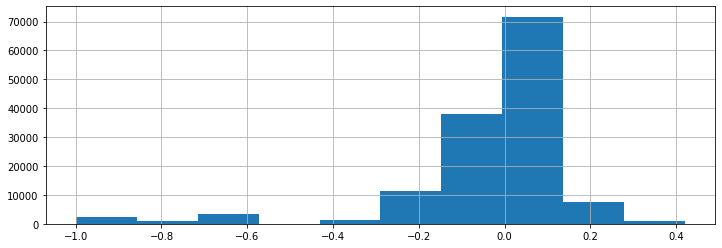

In [35]:
df_final['sdoh_avg'].hist()

In [36]:
df_final['sdoh_final']=(df_final['sdoh_avg']*10)

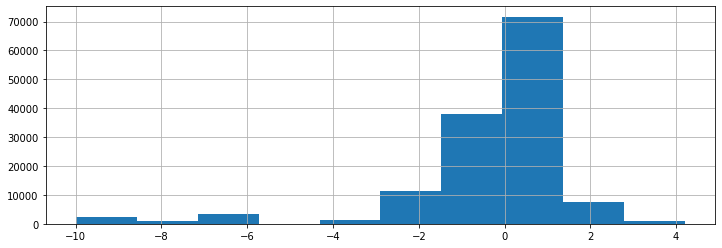

In [37]:
df_final['sdoh_final'].hist()

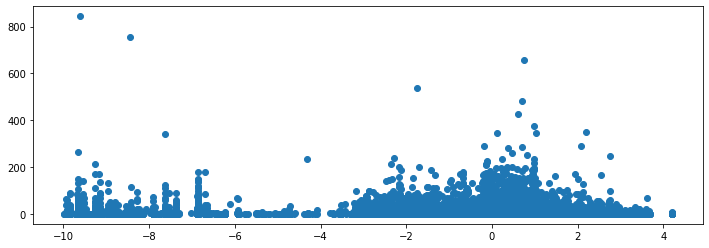

In [38]:
plt.scatter(df_final['sdoh_final'], df_final['cc_count'])

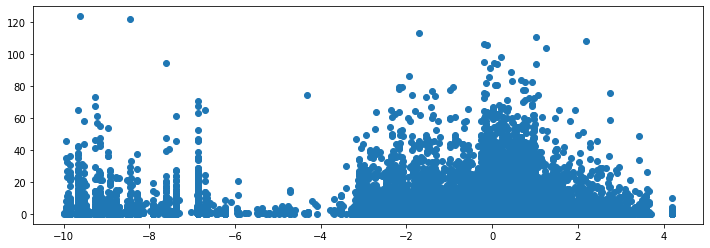

In [39]:
plt.scatter(df_final['sdoh_final'], df_final['risk_score'])

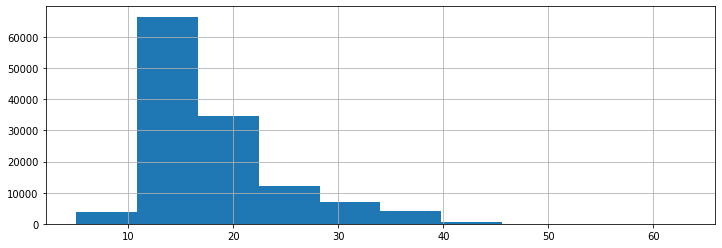

In [40]:
df_final['Social and Economic Factors Community Safety Suicides Suicide Rate (Age-Adjusted)'].hist()

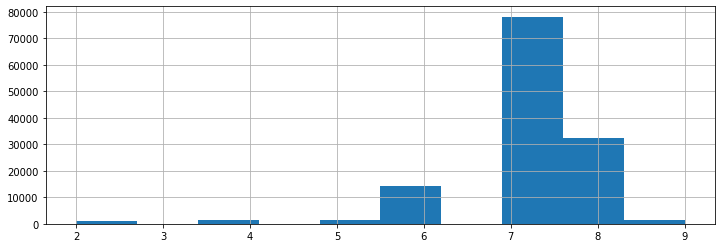

In [41]:
df_final['Health Behaviors Diet and Exercise Food Environment Index Food Environment Index'].hist()

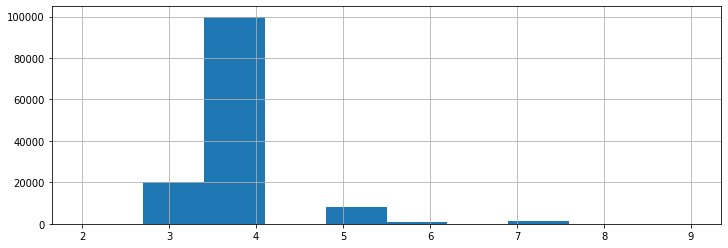

In [42]:
df_final['Social and Economic Factors Income Income Inequality Ratio of 80th Percentile HH income to 20th Percentile HH Income'].hist()

In [43]:
df_final.sort_values('sdoh_final',ascending=True).head(5)

,memberRecKey,clientDB,sex,age,mbrZipCode,mbrCounty,mbrState,providerZip,providerCounty,providerState,cc_count,risk_score,topic,subset,subset2,subset3,subset4,subset5,subset6,ZIP_x,county_name_x,state_abbrev_x,provider_wealth,measure_type,sdoh_feature,sdoh_9,ZIP_y,county_name_y,state_abbrev_y,COMMUTING TO WORK Workers 16 years and over Public transportation (excluding taxicab),INCOME AND BENEFITS (IN 2018 INFLATION-ADJUSTED DOLLARS) Total households Median household income (dollars),INCOME AND BENEFITS (IN 2018 INFLATION-ADJUSTED DOLLARS) Total households With Food Stamp/SNAP benefits in the past 12 months,INCOME AND BENEFITS (IN 2018 INFLATION-ADJUSTED DOLLARS) Total households With Social Security Mean Social Security income (dollars),INCOME AND BENEFITS (IN 2018 INFLATION-ADJUSTED DOLLARS) Total households With retirement income Mean retirement income (dollars),VETERAN STATUS Civilian population 18 years and over Civilian veterans,ZIP,county_name,state_abbrev,Clinical Care Access to Care Dentists # Dentists,Clinical Care Access to Care Mental Health Providers # Mental Health Providers,Clinical Care Access to Care PCPs # Primary Care Physicians,Clinical Care Access to Care Uninsured % Uninsured,Clinical Care Quality of Care Flu Vaccinations % Vaccinated for Flu,Clinical Care Quality of Care Mammography Screening % With Annual Mammogram,Demographics % Rural,Health Behaviors Alcohol and Drug Use Alcohol-impaired driving deaths % Driving Deaths with Alcohol Involvement,Health Behaviors Alcohol and Drug Use Drug Overdose Deaths Drug Overdose Mortality Rate,Health Behaviors Alcohol and Drug Use Excessive Drinking % Excessive Drinking,Health Behaviors Alcohol and Drug Use Motor Vehicle Crash Deaths Motor Vehicle Mortality Rate,Health Behaviors Diet and Exercise Adult Obesity % Adults with Obesity,Health Behaviors Diet and Exercise Food Environment Index Food Environment Index,Health Behaviors Diet and Exercise Food Insecurity % Food Insecure,Health Behaviors Diet and Exercise Physical Inactivity % Physically Inactive,Health Behaviors Other Health Behaviors Insufficient Sleep % Insufficient Sleep,Health Behaviors Other Health Behaviors Mental Health % Insufficient Sleep,Health Behaviors Sexual Activity STIs # Chlamydia Cases,Health Behaviors Sexual Activity Teen Births Teen Birth Rate,Health Behaviors Tobacco Use Adult Smoking % Smokers,Health Outcomes Length of Life Child Mortality Child Mortality Rate,Health Outcomes Length of Life Infant Mortality Infant Mortality Rate,Health Outcomes Length of Life Life Expectancy Life Expectancy,Health Outcomes Length of Life Premature Death Years of Potential Life Lost Rate,Health Outcomes Quality of Life Diabetes % Adults with Diabetes,Health Outcomes Quality of Life Mental Health % Frequent Mental Distress,Health Outcomes Quality of Life Mental Health Average Number of Mentally Unhealthy Days,Health Outcomes Quality of Life Physical Health % Frequent Physical Distress,Health Outcomes Quality of Life Physical Health Average Number of Physically Unhealthy Days,Health Outcomes Quality of Life STIs HIV Prevalence Rate,Physical Environment Air and Water Quality Air Pollution Average Daily PM2.5,Physical Environment Housing and Transit Homeownership % Homeowners,Physical Environment Housing and Transit Severe Housing Cost Burden % Severe Housing Cost Burden,Physical Environment Housing and Transit Severe Housing Problems % Severe Housing Problems,Social and Economic Factors Community Safety Firearm Fatalities Firearm Fatalities Rate,Social and Economic Factors Community Safety Homicides Homicide Rate,Social and Economic Factors Community Safety Injury Deaths Injury Death Rate,Social and Economic Factors Community Safety Juvenile Arrests Juvenile Arrest Rate,Social and Economic Factors Community Safety Suicides Suicide Rate (Age-Adjusted),Social and Economic Factors Community Safety Violent Crime Violent Crime Rate,Social and Economic Factors Education Academic Performance Average Grade Performanc

In [44]:
df_final_impute = df_final

In [45]:
df_final['sdoh_1']=df_final['Social and Economic Factors Education High School Graduation Rate High School Graduation Rate'].rank(pct=True)*-1
df_final['sdoh_2']=df_final['Health Behaviors Alcohol and Drug Use Alcohol-impaired driving deaths % Driving Deaths with Alcohol Involvement'].rank(pct=True)
df_final['sdoh_3']=df_final['Social and Economic Factors Community Safety Suicides Suicide Rate (Age-Adjusted)'].rank(pct=True)
df_final['sdoh_4']=df_final['Clinical Care Access to Care Uninsured % Uninsured'].rank(pct=True)
df_final['sdoh_5']=df_final['Social and Economic Factors Family and Social Support Social Associations Social Association Rate'].rank(pct=True)*-1
df_final['sdoh_6']=df_final['Health Behaviors Diet and Exercise Food Environment Index Food Environment Index'].rank(pct=True)*-1
df_final['sdoh_7']=df_final['Clinical Care Quality of Care Mammography Screening % With Annual Mammogram'].rank(pct=True)*-1
df_final['sdoh_8']=df_final['Social and Economic Factors Income Income Inequality Ratio of 80th Percentile HH income to 20th Percentile HH Income'].rank(pct=True)
df_final['sdoh_9']=df_final['provider_wealth'].rank(pct=True)*-1

In [46]:
sdoh_fields = ['sdoh_1','sdoh_2','sdoh_3','sdoh_4','sdoh_5','sdoh_6','sdoh_7','sdoh_8','sdoh_9']

In [47]:
for column in sdoh_fields:
    df_final_impute[column].fillna(df_final_impute[column].mean(), inplace=True)

In [48]:
df_final_impute['sdoh_avg'] = df_final_impute[['sdoh_1','sdoh_2','sdoh_3','sdoh_4','sdoh_5','sdoh_6','sdoh_7','sdoh_8','sdoh_9']].mean(axis=1)

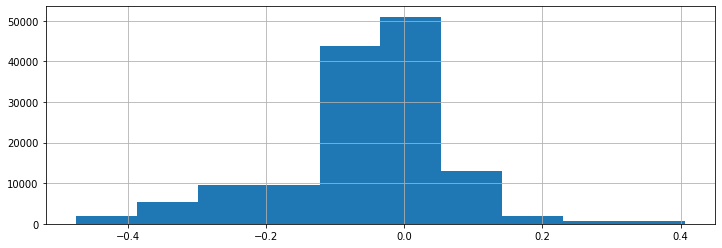

In [50]:
df_final_impute['sdoh_avg'].hist()

In [51]:
df_final_impute['sdoh_final']=(df_final_impute['sdoh_avg']*10)

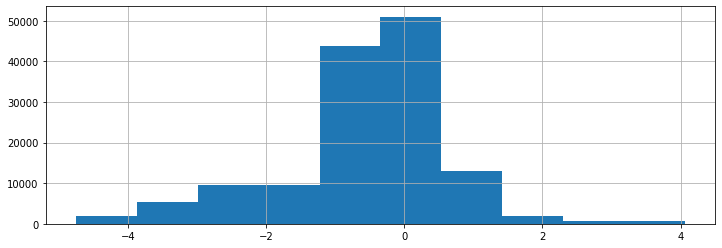

In [52]:
df_final_impute['sdoh_final'].hist()

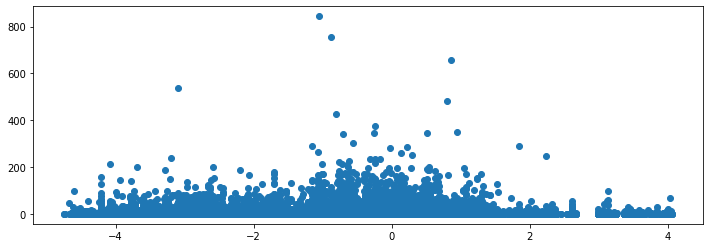

In [53]:
plt.scatter(df_final_impute['sdoh_final'], df_final_impute['cc_count'])

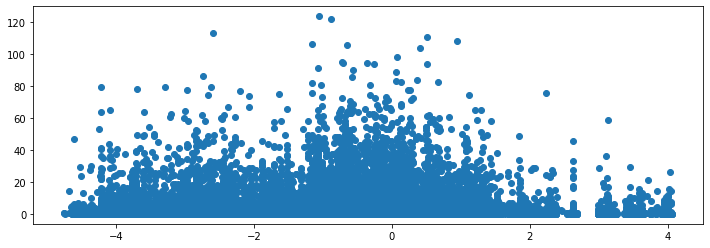

In [54]:
plt.scatter(df_final_impute['sdoh_final'], df_final_impute['risk_score'])

In [55]:
df_final_impute.sort_values('sdoh_final',ascending=True).head(5)

,memberRecKey,clientDB,sex,age,mbrZipCode,mbrCounty,mbrState,providerZip,providerCounty,providerState,cc_count,risk_score,topic,subset,subset2,subset3,subset4,subset5,subset6,ZIP_x,county_name_x,state_abbrev_x,provider_wealth,measure_type,sdoh_feature,sdoh_9,ZIP_y,county_name_y,state_abbrev_y,COMMUTING TO WORK Workers 16 years and over Public transportation (excluding taxicab),INCOME AND BENEFITS (IN 2018 INFLATION-ADJUSTED DOLLARS) Total households Median household income (dollars),INCOME AND BENEFITS (IN 2018 INFLATION-ADJUSTED DOLLARS) Total households With Food Stamp/SNAP benefits in the past 12 months,INCOME AND BENEFITS (IN 2018 INFLATION-ADJUSTED DOLLARS) Total households With Social Security Mean Social Security income (dollars),INCOME AND BENEFITS (IN 2018 INFLATION-ADJUSTED DOLLARS) Total households With retirement income Mean retirement income (dollars),VETERAN STATUS Civilian population 18 years and over Civilian veterans,ZIP,county_name,state_abbrev,Clinical Care Access to Care Dentists # Dentists,Clinical Care Access to Care Mental Health Providers # Mental Health Providers,Clinical Care Access to Care PCPs # Primary Care Physicians,Clinical Care Access to Care Uninsured % Uninsured,Clinical Care Quality of Care Flu Vaccinations % Vaccinated for Flu,Clinical Care Quality of Care Mammography Screening % With Annual Mammogram,Demographics % Rural,Health Behaviors Alcohol and Drug Use Alcohol-impaired driving deaths % Driving Deaths with Alcohol Involvement,Health Behaviors Alcohol and Drug Use Drug Overdose Deaths Drug Overdose Mortality Rate,Health Behaviors Alcohol and Drug Use Excessive Drinking % Excessive Drinking,Health Behaviors Alcohol and Drug Use Motor Vehicle Crash Deaths Motor Vehicle Mortality Rate,Health Behaviors Diet and Exercise Adult Obesity % Adults with Obesity,Health Behaviors Diet and Exercise Food Environment Index Food Environment Index,Health Behaviors Diet and Exercise Food Insecurity % Food Insecure,Health Behaviors Diet and Exercise Physical Inactivity % Physically Inactive,Health Behaviors Other Health Behaviors Insufficient Sleep % Insufficient Sleep,Health Behaviors Other Health Behaviors Mental Health % Insufficient Sleep,Health Behaviors Sexual Activity STIs # Chlamydia Cases,Health Behaviors Sexual Activity Teen Births Teen Birth Rate,Health Behaviors Tobacco Use Adult Smoking % Smokers,Health Outcomes Length of Life Child Mortality Child Mortality Rate,Health Outcomes Length of Life Infant Mortality Infant Mortality Rate,Health Outcomes Length of Life Life Expectancy Life Expectancy,Health Outcomes Length of Life Premature Death Years of Potential Life Lost Rate,Health Outcomes Quality of Life Diabetes % Adults with Diabetes,Health Outcomes Quality of Life Mental Health % Frequent Mental Distress,Health Outcomes Quality of Life Mental Health Average Number of Mentally Unhealthy Days,Health Outcomes Quality of Life Physical Health % Frequent Physical Distress,Health Outcomes Quality of Life Physical Health Average Number of Physically Unhealthy Days,Health Outcomes Quality of Life STIs HIV Prevalence Rate,Physical Environment Air and Water Quality Air Pollution Average Daily PM2.5,Physical Environment Housing and Transit Homeownership % Homeowners,Physical Environment Housing and Transit Severe Housing Cost Burden % Severe Housing Cost Burden,Physical Environment Housing and Transit Severe Housing Problems % Severe Housing Problems,Social and Economic Factors Community Safety Firearm Fatalities Firearm Fatalities Rate,Social and Economic Factors Community Safety Homicides Homicide Rate,Social and Economic Factors Community Safety Injury Deaths Injury Death Rate,Social and Economic Factors Community Safety Juvenile Arrests Juvenile Arrest Rate,Social and Economic Factors Community Safety Suicides Suicide Rate (Age-Adjusted),Social and Economic Factors Community Safety Violent Crime Violent Crime Rate,Social and Economic Factors Education Academic Performance Average Grade Performanc

In [56]:
df_final_impute.sort_values('sdoh_final',ascending=False).head(5)

,memberRecKey,clientDB,sex,age,mbrZipCode,mbrCounty,mbrState,providerZip,providerCounty,providerState,cc_count,risk_score,topic,subset,subset2,subset3,subset4,subset5,subset6,ZIP_x,county_name_x,state_abbrev_x,provider_wealth,measure_type,sdoh_feature,sdoh_9,ZIP_y,county_name_y,state_abbrev_y,COMMUTING TO WORK Workers 16 years and over Public transportation (excluding taxicab),INCOME AND BENEFITS (IN 2018 INFLATION-ADJUSTED DOLLARS) Total households Median household income (dollars),INCOME AND BENEFITS (IN 2018 INFLATION-ADJUSTED DOLLARS) Total households With Food Stamp/SNAP benefits in the past 12 months,INCOME AND BENEFITS (IN 2018 INFLATION-ADJUSTED DOLLARS) Total households With Social Security Mean Social Security income (dollars),INCOME AND BENEFITS (IN 2018 INFLATION-ADJUSTED DOLLARS) Total households With retirement income Mean retirement income (dollars),VETERAN STATUS Civilian population 18 years and over Civilian veterans,ZIP,county_name,state_abbrev,Clinical Care Access to Care Dentists # Dentists,Clinical Care Access to Care Mental Health Providers # Mental Health Providers,Clinical Care Access to Care PCPs # Primary Care Physicians,Clinical Care Access to Care Uninsured % Uninsured,Clinical Care Quality of Care Flu Vaccinations % Vaccinated for Flu,Clinical Care Quality of Care Mammography Screening % With Annual Mammogram,Demographics % Rural,Health Behaviors Alcohol and Drug Use Alcohol-impaired driving deaths % Driving Deaths with Alcohol Involvement,Health Behaviors Alcohol and Drug Use Drug Overdose Deaths Drug Overdose Mortality Rate,Health Behaviors Alcohol and Drug Use Excessive Drinking % Excessive Drinking,Health Behaviors Alcohol and Drug Use Motor Vehicle Crash Deaths Motor Vehicle Mortality Rate,Health Behaviors Diet and Exercise Adult Obesity % Adults with Obesity,Health Behaviors Diet and Exercise Food Environment Index Food Environment Index,Health Behaviors Diet and Exercise Food Insecurity % Food Insecure,Health Behaviors Diet and Exercise Physical Inactivity % Physically Inactive,Health Behaviors Other Health Behaviors Insufficient Sleep % Insufficient Sleep,Health Behaviors Other Health Behaviors Mental Health % Insufficient Sleep,Health Behaviors Sexual Activity STIs # Chlamydia Cases,Health Behaviors Sexual Activity Teen Births Teen Birth Rate,Health Behaviors Tobacco Use Adult Smoking % Smokers,Health Outcomes Length of Life Child Mortality Child Mortality Rate,Health Outcomes Length of Life Infant Mortality Infant Mortality Rate,Health Outcomes Length of Life Life Expectancy Life Expectancy,Health Outcomes Length of Life Premature Death Years of Potential Life Lost Rate,Health Outcomes Quality of Life Diabetes % Adults with Diabetes,Health Outcomes Quality of Life Mental Health % Frequent Mental Distress,Health Outcomes Quality of Life Mental Health Average Number of Mentally Unhealthy Days,Health Outcomes Quality of Life Physical Health % Frequent Physical Distress,Health Outcomes Quality of Life Physical Health Average Number of Physically Unhealthy Days,Health Outcomes Quality of Life STIs HIV Prevalence Rate,Physical Environment Air and Water Quality Air Pollution Average Daily PM2.5,Physical Environment Housing and Transit Homeownership % Homeowners,Physical Environment Housing and Transit Severe Housing Cost Burden % Severe Housing Cost Burden,Physical Environment Housing and Transit Severe Housing Problems % Severe Housing Problems,Social and Economic Factors Community Safety Firearm Fatalities Firearm Fatalities Rate,Social and Economic Factors Community Safety Homicides Homicide Rate,Social and Economic Factors Community Safety Injury Deaths Injury Death Rate,Social and Economic Factors Community Safety Juvenile Arrests Juvenile Arrest Rate,Social and Economic Factors Community Safety Suicides Suicide Rate (Age-Adjusted),Social and Economic Factors Community Safety Violent Crime Violent Crime Rate,Social and Economic Factors Education Academic Performance Average Grade Performanc

In [58]:
df_final_impute[['mbrZipCode','mbrCounty','mbrState','sdoh_final']].sort_values('sdoh_final',ascending=False).drop_duplicates()

,mbrZipCode,mbrCounty,mbrState,sdoh_final
68915,85938,APACHE,AZ,4.059249
73675,85938,APACHE,AZ,4.056528
48063,85936,APACHE,AZ,4.054548
2215,85936,APACHE,AZ,4.048649
10684,85924,APACHE,AZ,4.048649
17562,85925,APACHE,AZ,4.048649
34259,85938,APACHE,AZ,4.048649
66121,85936,APACHE,AZ,4.034665
33625,85927,APACHE,AZ,4.033982
55297,85938,APACHE,AZ,4.023153


In [59]:
df_final_export = df_final_impute[['mbrZipCode','mbrCounty','mbrState','sdoh_final']].sort_values('sdoh_final',ascending=False).drop_duplicates()

In [60]:
df_final_export = df_final_export.groupby(['mbrZipCode','mbrCounty','mbrState']).mean().reset_index()

In [61]:
df_final_export.to_csv('df_sdoh_score.csv')